# UPC Quantum Engineering Final Project: Quantum Channel Discrimination
## II. One-shot discrimination Base circuit

In [1]:
from itertools import product, combinations
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
from qiskit import Aer, execute
from numpy import pi
from math import e
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Create 2 qbits circuit and 1 output classical bit
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(1, 'c')
pointsTheta = 10  # Points of Theta angle (pi) in Bloch sphere - min 2
pointsPhase = 20  # Points of Phase angle (2*pi) in Bloch sphere - min 2
angleCYgate = pi/1.5  # Angle used for CY gate
# angles shift from first parameter, to the second one, with jumps using the third parameter
# anglesCYgate = np.arange(0, 2*pi, 2*pi/10)
iterations = 5000  # Number of iterations in execution

# Quantum states to pass through the circuit
# We want to pass the Bloch sphere through it to see visually the transformation
# First we generate the angles which will help the draw the sphere
anglesTheta = np.mgrid[0:pi:pointsTheta*1j]
anglesPhase = np.mgrid[0:2*pi:pointsPhase*1j]


In [3]:
print('Preparing initial states to pass through the circuit')
# As we have to provide the state values to initialize the qreg[0] we have to do a conversion
# from angles in the sphere to statevector amplitudes. These statevectors will be the combination of
# Zero_Amplitude*|0> plus One_Amplitude*|1>
initialStatesZeroAmplitude = []
initialStatesOneAmplitude = []

for indexTheta in range(len(anglesTheta)):
    for indexPhase in range(len(anglesPhase)):
        initialStatesZeroAmplitude.append(math.cos(anglesTheta[indexTheta]/2))
        initialStatesOneAmplitude.append(math.sin(anglesTheta[indexTheta]/2)*e**(1j*anglesPhase[indexPhase]))
# List of Initial States
        # print("State ", indexTheta*P+indexPhase," =", initialStatesZeroAmplitude[indexTheta*P+indexPhase],"*|0> + ", initialStatesOneAmplitude[indexTheta*P+indexPhase], "*|1>")

Preparing initial states to pass through the circuit


In [4]:
# convert the results of a simulation to a final state: aplha*|0> + beta*|1>
def convertCountsToFinalState(inCounts):
    countsZero = 0
    countsOne = 0

    if "0" in inCounts:
        countsZero = inCounts["0"]
    if "1" in inCounts:
        countsOne = inCounts["1"]

    totalCycles = countsZero + countsOne
    
    return {
        "zeroAmplitude": np.sqrt(countsZero/totalCycles),
        "oneAmplitude": np.sqrt(countsOne/totalCycles),
    }

In [5]:
print("Defining the circuit")
# Create the circuit gates
# Not used as we defined the angle and don't iterate circuits
# print("Starting to compute the angle: ", math.degrees(theta))


totalResults = []
totalCounts = []
totalCircuits = []
finalStatesZeroAmplitude = []
finalStatesOneAmplitude = []
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Initialize circuit with desired initial_state
print("Initializing the circuit")

for indexInitialState in range(len(initialStatesZeroAmplitude)):
    circuit = QuantumCircuit(qreg_q, creg_c)
    circuit.initialize([initialStatesZeroAmplitude[indexInitialState], initialStatesOneAmplitude[indexInitialState]], qreg_q[0])
   #print("Input State ", i, " =",
    #      np.round(Zero_Amplitude[i], 3), "*|0> + ", np.round(One_Amplitude[i],3), "*|1>")
    circuit.reset(qreg_q[1])
    circuit.cry(angleCYgate, qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])
    totalCircuits.append(circuit)
    # execute circuit on backends
    job_sim = execute(circuit, backend_sim, shots=iterations)
    # get results
    results_sim = job_sim.result()
    #print("Output State Vector: ", outputState)
    totalResults.append(results_sim)
    counts = results_sim.get_counts(circuit)
    finalState = convertCountsToFinalState(counts)
    finalStatesZeroAmplitude.append(finalState["zeroAmplitude"])
    finalStatesOneAmplitude.append(finalState["oneAmplitude"])
    #print("Output State ", i, " =",
    #      np.round(Zero_AmplitudeF[i],3), "*|0> + ", np.round(One_AmplitudeF[i],3), "*|1>")
    totalCounts.append(counts)

Defining the circuit
Initializing the circuit


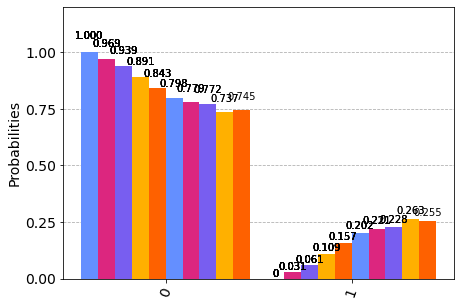

In [6]:
plot_histogram([totalCounts[0], totalCounts[int((len(totalCounts)/10)*2)], totalCounts[int((len(totalCounts)/10)*3)], totalCounts[int((len(totalCounts)/10)*4)], totalCounts[int((len(totalCounts)/10)*5)], totalCounts[int((len(totalCounts)/10)*6)],totalCounts[int((len(totalCounts)/10)*7)], totalCounts[int((len(totalCounts)/10)*8)], totalCounts[int((len(totalCounts)/10)*9)], totalCounts[(int((len(totalCounts)/10)*10))-1]])

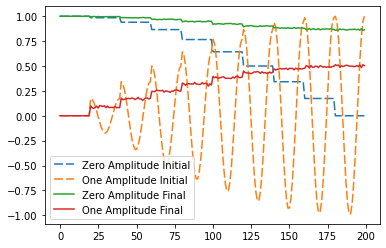

In [7]:
fig, ax = plt.subplots()

line1, = ax.plot(initialStatesZeroAmplitude, dashes=[6, 2], label='Zero Amplitude Initial')
line2, = ax.plot(initialStatesOneAmplitude, dashes=[6, 2], label='One Amplitude Initial')

line3, = ax.plot(finalStatesZeroAmplitude, label='Zero Amplitude Final')
line4, = ax.plot(finalStatesOneAmplitude, label='One Amplitude Final')

ax.legend()
plt.show()

## Plotting the results

In [8]:
def computeStateVectorCoordsReshaped(amplitudesVector, inputAnglesPhase, nPointsTheta, nPointsPhase):
    initialStateVectorCoordsX = []
    initialStateVectorCoordsY = []
    initialStateVectorCoordsZ = []
    for indexAmplitudes in range(len(amplitudesVector)):
        Theta_i = 2*np.arccos(amplitudesVector[indexAmplitudes])
        Phase_i = inputAnglesPhase[indexAmplitudes % nPointsPhase]
        initialStateVectorCoordsX.append(np.sin(Theta_i)*np.cos(Phase_i))
        initialStateVectorCoordsY.append(np.sin(Theta_i)*np.sin(Phase_i))
        initialStateVectorCoordsZ.append(np.cos(Theta_i))
    # Reshaping matrices X, Y and Z in right dimensions to be represented
    return {
        'reshapedCoordsX':  np.reshape(initialStateVectorCoordsX, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsY':  np.reshape(initialStateVectorCoordsY, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsZ':  np.reshape(initialStateVectorCoordsZ, (nPointsTheta, nPointsPhase)),
    }

In [9]:
# function that draw a cube passing axes as a parameter
def draw_cube(axes):
    # draw cube
    r = [-1, 1]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s-e)) == r[1]-r[0]:
            axes.plot3D(*zip(s, e), color="w")

### Plotting both Initial States and Final States

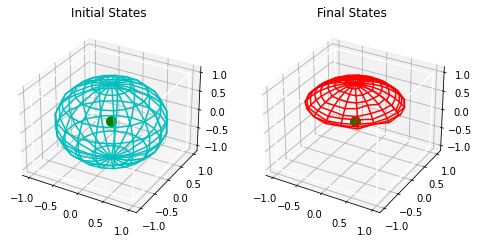

In [10]:
# Set the Initial States
initialStates = computeStateVectorCoordsReshaped(initialStatesZeroAmplitude, anglesPhase, pointsTheta, pointsPhase)
# Set the Final States
finalStates = computeStateVectorCoordsReshaped(finalStatesZeroAmplitude, anglesPhase, pointsTheta, pointsPhase)
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
draw_cube(ax)

# draw initial states
ax.plot_wireframe(initialStates['reshapedCoordsX'], initialStates['reshapedCoordsY'], initialStates['reshapedCoordsZ'], color="c")
ax.set_title("Initial States")
# draw center
ax.scatter([0], [0], [0], color="g", s=100)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
draw_cube(ax)
# draw final states
ax.plot_wireframe(finalStates['reshapedCoordsX'], finalStates['reshapedCoordsY'], finalStates['reshapedCoordsZ'], color="r")
ax.set_title("Final States")
# draw center
ax.scatter([0], [0], [0], color="g", s=100)

plt.show()